In [1]:
import pandas as pd
import numpy as np
import time
import datetime 
from dateutil.parser import parse
from datetime import date, timedelta
from pandas.tseries.offsets import *

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import *
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn import *
from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor
import pickle
from lunar import *
from copy import deepcopy

%matplotlib inline

/home/yuanhao/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/yuanhao/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/home/yuanhao/anaconda3/lib/python3.6/site-packages/sklearn/lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWar

## data 集初步整理

In [2]:
df_train = pd.read_table('fusai_train_20180227.txt',encoding='gbk',sep='\t')

In [3]:
df_train.tail()

,date,day_of_week,brand,cnt
8966,1107,4,3,235
8967,1107,4,4,348
8968,1107,4,5,350
8969,1107,4,6,285
8970,1107,4,7,232


## 日期分析

In [4]:
df_grouped = df_train.groupby(['date','day_of_week']).cnt.agg('sum').reset_index()

In [5]:
df_grouped.head()

,date,day_of_week,cnt
0,1,2,52
1,2,3,104
2,3,4,43
3,4,5,7034
4,5,6,5607


In [6]:
df_grouped['gap']=0

for idx, row in df_grouped.iterrows():
    if idx==0:
        df_grouped.loc[idx,:]['gap']=1
        continue
    df_grouped.loc[idx, 'gap']=df_grouped.loc[idx,'day_of_week']-df_grouped.loc[idx-1,'day_of_week']
    while df_grouped.loc[idx,'gap']<=0:
         df_grouped.loc[idx,'gap']+=7

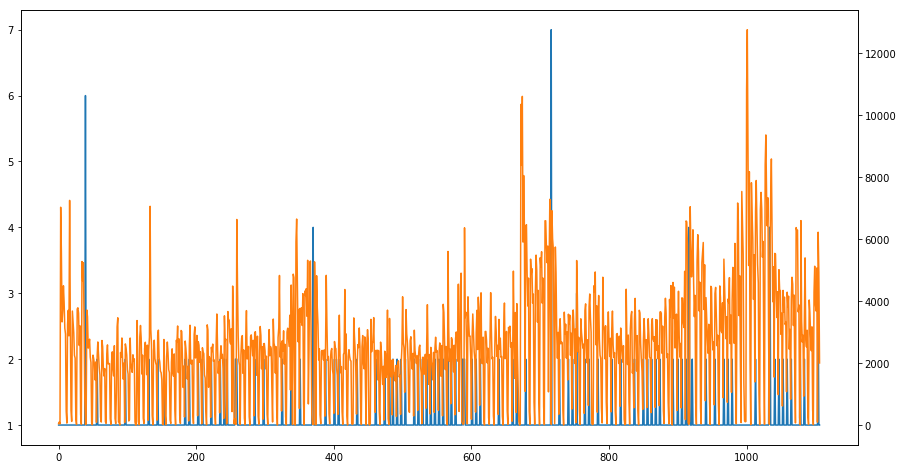

In [7]:
df_grouped['gap'].plot(figsize=(15,8))
df_grouped['cnt'].plot(figsize=(15,8), secondary_y=True)

真实日期推测，技术圈里有相关文章我就不赘述了。数据集的第一天应该是2013年1月1日。

## 补0

观察数据可以发现有的date并非有所有的brand数据，这里把所有brand的数据都补上。

In [8]:
to_concat = {'date':[],
            'day_of_week':[],
            'brand':[],
            'cnt':[]}
for d in df_train['date'].unique():
    df_temp = df_train[df_train['date']==d]
    dow = df_temp.iloc[0,1]
    for b in range(1,10):
        if b not in df_temp['brand'].unique():
            to_concat['date'].append(d)
            to_concat['day_of_week'].append(dow)
            to_concat['brand'].append(b)
            to_concat['cnt'].append(0)
df_train = df_train.append(pd.DataFrame(to_concat, columns=df_train.columns))
df_train = df_train.sort_values(by='date')

In [9]:
train_index = df_train.shape[0]
train_y = df_train['cnt']
print(df_train.shape)

(10948, 4)


## 读取a榜和b榜数据

In [10]:
df_test = pd.read_table('fusai_test_A_20180227.txt',encoding='gbk',sep='\t')

In [11]:
df_test.head()

,date,day_of_week,brand
0,1107,4,7
1,1107,4,8
2,1107,4,9
3,1107,4,10
4,1108,5,1


In [12]:
df_testa_answer = pd.read_table('fusai_answer_a_20180307.txt', sep='\t',header=None)

In [13]:
df_testa_answer.head()

,0,1,2
0,1107,7,232
1,1107,8,583
2,1107,9,466
3,1107,10,288
4,1108,1,490


In [14]:
df_testa_answer.rename(index=str, columns={0:'date',1:'brand',2:'cnt'},inplace=True)

In [15]:
print(df_test.shape)
print(df_testa_answer.shape)

(1289, 3)
(1289, 3)


In [16]:
df_test['cnt'] = df_testa_answer['cnt'].values

In [17]:
test_index = df_test['date']

In [18]:
df_test2 = pd.read_table('fusai_test_B_20180227.txt',encoding='gbk',sep='\t')

## 合成全数据集

In [19]:
df_test2.shape

(3541, 3)

In [20]:
df = pd.concat([df_train, df_test, df_test2]) #

In [21]:
train_index = df_train.shape[0]+df_test.shape[0]
train_y = df['cnt'].iloc[0:train_index]

In [22]:
print(df.shape)
print(df.shape[0]-train_index)
print(train_y.shape)

(15778, 4)
3541
(12237,)


In [23]:
# df_grouped是对每天的所有品牌求和后的数据，方便后面提特征
df_grouped = df[['date','day_of_week','cnt']].groupby(['date','day_of_week']).cnt.agg('sum').reset_index()
df_grouped.head()

,date,day_of_week,cnt
0,1,2,52.0
1,2,3,104.0
2,3,4,43.0
3,4,5,7034.0
4,5,6,5607.0


In [24]:
df_grouped = df_grouped.drop_duplicates()

## 特征工程

In [25]:
# 首先是还原真实日期
df_grouped['gap']=0

for idx, row in df_grouped.iterrows():
    if idx==0:
        df_grouped.loc[idx,:]['gap']=1
        continue
    df_grouped.loc[idx, 'gap']=df_grouped.loc[idx,'day_of_week']-df_grouped.loc[idx-1,'day_of_week']
    while df_grouped.loc[idx,'gap']<=0:
         df_grouped.loc[idx,'gap']+=7

df_grouped['virtual_date']=pd.NaT

for idx, row in df_grouped.iterrows():
    if idx==0:
        d=datetime.date(2013,1,1)
        while d.weekday()!=df_grouped.loc[idx,'day_of_week']-1:
            d += DateOffset(days=1)
        df_grouped.loc[idx, 'virtual_date']=d
        continue
    df_grouped.loc[idx, 'virtual_date']=df_grouped.loc[idx-1,'virtual_date']+DateOffset(days=row['gap'])

/home/yuanhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [26]:
df_grouped.tail()

,date,day_of_week,cnt,gap,virtual_date
1635,1636,5,0.0,1,2017-11-24
1636,1637,6,0.0,1,2017-11-25
1637,1638,7,0.0,1,2017-11-26
1638,1639,1,0.0,1,2017-11-27
1639,1640,2,0.0,1,2017-11-28


In [27]:
# get all the holidays
holidays={'date':[],
          'length':[]}
for idx, row in df_grouped.iterrows():
    if row['gap']>2:
        holidays['length'].append(row['gap'])
        holidays['date'].append(row['virtual_date']+DateOffset(days=-(row['gap']//2)))
# convert to DataFrame
holidays_df = pd.DataFrame(holidays, columns=['date','length'])

In [28]:
# 年月日基础特征
df_grouped['month']=df_grouped['virtual_date'].dt.month
df_grouped['year']=df_grouped['virtual_date'].dt.year
df_grouped['week']=df_grouped['virtual_date'].dt.week
df_grouped['day']=df_grouped['virtual_date'].dt.day
df_grouped['xun'] = df_grouped['day'].apply(lambda x: x//7)  # 第几周

In [29]:
# 农历年月日特征
cvt = LunarSolarConverter()
df_grouped['lunar_month']=df_grouped['virtual_date'].apply(lambda x: cvt.SolarToLunar(Solar(x.year,x.month,x.day)).lunarMonth)
df_grouped['lunar_day']=df_grouped['virtual_date'].apply(lambda x: cvt.SolarToLunar(Solar(x.year,x.month,x.day)).lunarDay)
df_grouped['lunar_year']=df_grouped['virtual_date'].apply(lambda x: cvt.SolarToLunar(Solar(x.year,x.month,x.day)).lunarYear)
df_grouped['lunar_xun'] = df_grouped['lunar_day'].apply(lambda x: x//7)

In [30]:
df_grouped = df_grouped.drop('cnt', axis=1)

In [31]:
df = df.merge(df_grouped.drop('day_of_week',axis=1),on='date',how='left')

In [32]:
# 只能统计train中数据
df_temp = deepcopy(df.iloc[0:train_index,:])
df_temp['cnt'] = train_y.values

In [33]:
# 历史特征，这里先聚合出公历每月、农历每月、公历月精确到周，农历月精确到周的一些统计信息
solar_cols = ['cnt','month','year','brand']
solar_cols2 = ['cnt','month','year','brand','xun']
lunar_cols = ['cnt','lunar_month','lunar_year','brand']
lunar_cols2 = ['cnt','lunar_month','lunar_year','brand','lunar_xun']
solar_history = pd.DataFrame(df_temp[solar_cols].groupby(['brand','month','year']).cnt.agg({'s_mean':'mean',
#                                                                                     's_median':'median',
                                                                                    's_skew':'skew',
                                                                                    's_count':'count'})).reset_index()
solar_history_xun = pd.DataFrame(df_temp[solar_cols2].groupby(['brand','month','year','xun']).cnt.agg({'sx_mean':'mean',
                                                                                                'sx_median':'median',
                                                                                                'sx_max':'max',
                                                                                                'sx_min':'min',
                                                                                                'sx_count':'count',
                                                                                                'sx_std':'std'})).reset_index()

lunar_history = pd.DataFrame(df_temp[lunar_cols].groupby(['brand','lunar_month', 'lunar_year']).cnt.agg({'l_mean':'mean',
                                                                                                 'l_median':'median',
                                                                                                 'l_count':'count',
                                                                                                 'l_skew':'skew'})).reset_index()
                             
lunar_history_xun = pd.DataFrame(df_temp[lunar_cols2]).groupby(['brand','lunar_month','lunar_year','lunar_xun']).cnt.agg({'lx_mean':'mean',
                                                                                                'lx_median':'median',
                                                                                                'lx_max':'max',
                                                                                                'lx_min':'min',
                                                                                                'lx_count':'count',
                                                                                                'lx_std':'std'}).reset_index()

/home/yuanhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/home/yuanhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  from ipykernel import kernelapp as app
/home/yuanhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
/home/yuanhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


In [34]:
# 修改列名，方便merge
solar_history = solar_history.rename(index=str,columns= {'year':'last_year'})
solar_history_xun = solar_history_xun.rename(index=str, columns={'year':'last_year'})
lunar_history = lunar_history.rename(index=str, columns={'lunar_year':'last_lunar_year'})
lunar_history_xun = lunar_history_xun.rename(index=str, columns={'lunar_year':'last_lunar_year'})

In [35]:
# 对日期做平移，默认平移一年，2016年10月11月的数据不存在，所以2017年相关数据平移两年
df['last_year'] = df['year']-1
df['last_lunar_year'] = df['lunar_year']-1
df.loc[df['virtual_date']>date(2017,9,30),'last_year'] = df['year']-2

In [37]:
df.shape

(15778, 17)

In [39]:
# merge
df = df.merge(solar_history, on=['last_year','month','brand'],how='left')
df = df.merge(solar_history_xun, on=['last_year','month','xun','brand'],how='left')
df = df.merge(lunar_history, on=['last_lunar_year','lunar_month','brand'],how='left')
df = df.merge(lunar_history_xun, on=['last_lunar_year','lunar_month','lunar_xun','brand'],how='left')

## 假期特征

In [41]:
# holiday_v2.csv 是从网上爬的数据，只有一列特征，即该日是不是法定节假日
holiday_df = pd.read_csv('holiday_v2.csv')
holiday_df['virtual_date'] = pd.to_datetime(holiday_df['virtual_date'])

In [42]:
df = df.merge(holiday_df, on=['virtual_date'],how='left')

In [43]:
# 前后两天是不是法定节假日
holiday_series = holiday_df.set_index('virtual_date')
df['yesterday_hld'] = df['virtual_date'].apply(lambda x: holiday_series.loc[x+DateOffset(days=-1),'hld'])
df['tomorrow_hld'] = df['virtual_date'].apply(lambda x: holiday_series.loc[x+DateOffset(days=1),'hld'])

In [44]:
def get_month_type(x):
    if x in [1,10]:
        return 1
    elif x in [9,12]:
        return 2
    else:
        return 0

In [45]:
# 这两个特征是我编的，把月份和品牌分成几类
df['month_type'] = df['month'].apply(lambda x: get_month_type(x))

df['brand_type'] = df['brand'].apply(lambda x: 1 if x in [5,8,9] else 0)

In [46]:
# 这是提取的另一个特征文件，包含以下几个特征
# 该日是某段连续工作日中的正数第几天、倒数第几天
# 该日距离春节、五一、国庆、元旦有几天
data_feature = pd.read_csv('data_feature-v2.csv')

In [47]:
data_feature['virtual_date'] = pd.to_datetime(data_feature['virtual_date'])
df['virtual_date'] = pd.to_datetime(df['virtual_date'])

In [48]:
df = df.merge(data_feature, on='virtual_date',how='left')

## 最接近日

In [49]:
# 这是一个比较重要的特征，对于某一天day，我先计算出去年与它特性最接近的一天的日期，然后s_date_cnt是这个与它最接近日期的上牌量
df_copy = df[['virtual_date','brand','cnt']].copy()

df['s_date'] = pd.to_datetime(df['s_date'])

df = df.merge(df_copy,left_on=['s_date','brand'],right_on=['virtual_date','brand'],how='left')

print(df.shape)
print(df_copy.shape)


df = df.drop('virtual_date_y',axis=1).rename(index=str, columns={'virtual_date_x':'virtual_date',
                                                                'cnt_y':'s_date_cnt',
                                                                'cnt_x':'cnt'})

df['s_date_cnt'].isnull().sum()

(15778, 51)
(15778, 3)


3737

## cv

In [50]:
train_df2 = df[(df['virtual_date']<date(2015,10,12)) ] #& (df['virtual_date']>=date(2014,1,1))
valid_df2 = df[(df['virtual_date']>=date(2015,10,12)) & (df['virtual_date']<date(2016,10,12))]

train_X2 = train_df2.drop(['cnt','date','virtual_date','s_date'], axis=1)
train_Y2 = train_df2['cnt']
valid_X2 = valid_df2.drop(['cnt','date','virtual_date','s_date'], axis =1)
valid_Y2 = valid_df2['cnt']


In [51]:
print(df.shape)
print(valid_Y2.shape)
print(train_X2.shape)

(15778, 50)
(3128,)
(9109, 46)


In [52]:
train_X2.columns

Index(['brand', 'day_of_week', 'gap', 'month', 'year', 'week', 'day', 'xun',
       'lunar_month', 'lunar_day', 'lunar_year', 'lunar_xun', 'last_year',
       'last_lunar_year', 's_mean', 's_skew', 's_count', 'sx_mean',
       'sx_median', 'sx_max', 'sx_min', 'sx_count', 'sx_std', 'l_mean',
       'l_median', 'l_count', 'l_skew', 'lx_mean', 'lx_median', 'lx_max',
       'lx_min', 'lx_count', 'lx_std', 'hld', 'yesterday_hld', 'tomorrow_hld',
       'month_type', 'brand_type', 'ith_workday', 'ith_workday_r',
       'spring_distance', 'ld_distance', 'nd_distance', 'ny_distance',
       'ny_distance2', 's_date_cnt'],
      dtype='object')

In [53]:
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

In [54]:
month_idx = train_X2.columns.tolist().index('month')
brandtype_idx = train_X2.columns.tolist().index('brand_type')
monthtype_idx = train_X2.columns.tolist().index('month_type')

In [55]:
# 尝试过加权重，提升不大
weight = 1**(2016-train_X2['year'])

In [56]:
# 三种模型做ensamble，还做了bagging提升稳定性
predict = 0
bagging_num = 2
for i in range(bagging_num): 
   model1 = ensemble.ExtraTreesRegressor(n_jobs=-1, n_estimators=1200, max_depth=10, max_features=0.6,
                                          min_samples_split = 5, random_state = i*3)
   model1.fit(train_X2.fillna(-999), train_Y2, sample_weight=weight.values)
   predict +=  1*model1.predict(valid_X2.fillna(-999))
    

   model1 = LGBMRegressor(learning_rate=0.020, n_estimators=1200, subsample=0.8, max_depth=6, num_leaves=32,
                          min_child_samples=5, colsample_bytree=0.5, reg_lambda=0.02, random_seed = i*3)
   model1.fit(train_X2.fillna(-1), train_Y2, categorical_feature=['month_type','brand_type','month'],sample_weight=weight.values)
   predict +=  model1.predict(valid_X2.fillna(-1))

   model2 = CatBoostRegressor(iterations=1400, learning_rate=0.07, depth=4, l2_leaf_reg=3, loss_function='RMSE', 
                          eval_metric='RMSE',  logging_level='Silent', random_seed=i*5)
   model2.fit(train_X2.fillna(-1), train_Y2,cat_features=[month_idx,brandtype_idx,monthtype_idx],eval_set=(valid_X2.fillna(-1),valid_Y2),
             sample_weight = weight.values)
   predict += model2.predict(valid_X2.fillna(-1))
predict = predict/bagging_num/3

/home/yuanhao/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1029: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['brand_type', 'month', 'month_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/yuanhao/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1029: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['brand_type', 'month', 'month_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [57]:
error = predict - valid_Y2
metric= np.mean(np.square(error))
print(np.sum(np.square(error)))
print(metric)

133213151.676
42587.324704703715


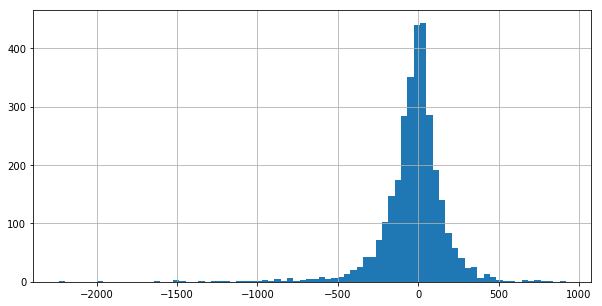

In [58]:
pd.Series(error).hist(bins=80,figsize=(10,5))

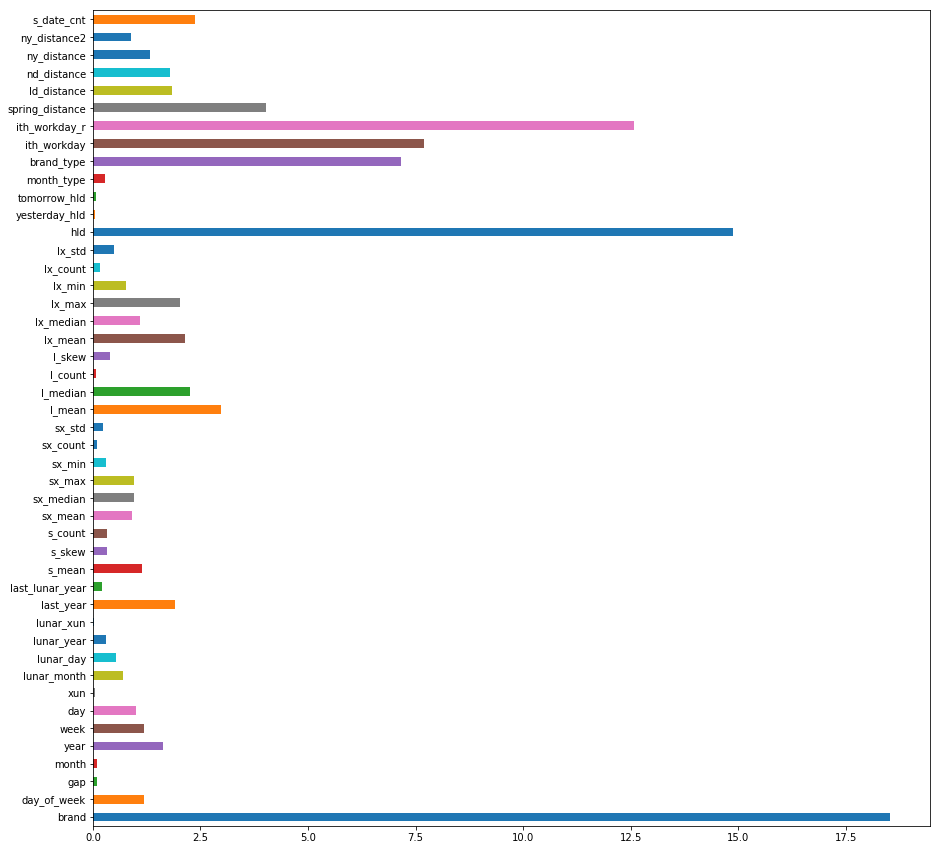

In [59]:
pd.Series(model2.feature_importances_, index=train_X2.columns).plot.barh(figsize=(15,15))

### 测试

In [325]:
train_df = df.iloc[:train_index,:]
test_df = df.iloc[train_index:,:]

In [326]:
print(train_df.shape)
print(test_df.shape)

(12237, 50)
(3541, 50)


In [327]:
train_X = train_df.drop(['cnt','date','virtual_date','s_date'], axis=1)
train_Y = train_df['cnt']
test_X = test_df.drop(['cnt','date','virtual_date','s_date'], axis =1)
print(train_X.shape)
month_idx = train_X.columns.tolist().index('month')
brandtype_idx = train_X.columns.tolist().index('brand_type')
monthtype_idx = train_X.columns.tolist().index('month_type')

(12237, 46)


In [328]:
predict = 0
bagging_num = 2
for i in range(bagging_num):
    model1 = ensemble.ExtraTreesRegressor(n_jobs=-1, n_estimators=1200, max_depth=10, max_features=0.6,
                                           min_samples_split = 5, random_state = i*3)
    model1.fit(train_X.fillna(-999), train_Y)
    predict +=  1*model1.predict(test_X.fillna(-999))
    
    model1 = LGBMRegressor(learning_rate=0.020, n_estimators=1200, subsample=0.8, max_depth=6, num_leaves=32, 
                           min_child_samples=5, colsample_bytree=0.35, reg_lambda=0.01, random_seed = i*3)
    model1.fit(train_X.fillna(-1), train_Y, categorical_feature=['month_type','brand_type'])
    predict +=  model1.predict(test_X.fillna(-1))

    model2 = CatBoostRegressor(iterations=1400, learning_rate=0.06, depth=4, l2_leaf_reg=3, loss_function='RMSE', 
                           eval_metric='RMSE',  random_seed=i*5)
    model2.fit(train_X.fillna(-1), train_Y,cat_features=[month_idx,monthtype_idx,brandtype_idx])
    predict += model2.predict(test_X.fillna(-1))
predict = predict/bagging_num/3

/home/yuanhao/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1029: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['brand_type', 'month_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


0:	learn: 354.4657930	total: 7.89ms	remaining: 11s
1:	learn: 339.4525800	total: 15.6ms	remaining: 10.9s
2:	learn: 325.8727225	total: 23.1ms	remaining: 10.7s
3:	learn: 313.2234266	total: 30.3ms	remaining: 10.6s
4:	learn: 301.2077479	total: 37.3ms	remaining: 10.4s
5:	learn: 290.5186718	total: 44.3ms	remaining: 10.3s
6:	learn: 280.1630076	total: 52.9ms	remaining: 10.5s
7:	learn: 270.5879442	total: 62ms	remaining: 10.8s
8:	learn: 262.0331140	total: 71.5ms	remaining: 11s
9:	learn: 253.9669186	total: 80.1ms	remaining: 11.1s
10:	learn: 246.4382250	total: 88.4ms	remaining: 11.2s
11:	learn: 240.0390528	total: 96.4ms	remaining: 11.2s
12:	learn: 233.5610147	total: 106ms	remaining: 11.4s
13:	learn: 227.6537962	total: 114ms	remaining: 11.3s
14:	learn: 222.2172810	total: 121ms	remaining: 11.2s
15:	learn: 217.4206842	total: 128ms	remaining: 11.1s
16:	learn: 212.8304351	total: 135ms	remaining: 11s
17:	learn: 208.6985034	total: 142ms	remaining: 10.9s
18:	learn: 204.5008060	total: 154ms	remaining: 11.2s

159:	learn: 138.0140183	total: 1.42s	remaining: 11s
160:	learn: 137.9375424	total: 1.43s	remaining: 11s
161:	learn: 137.8561139	total: 1.44s	remaining: 11s
162:	learn: 137.8126223	total: 1.45s	remaining: 11s
163:	learn: 137.7753290	total: 1.46s	remaining: 11s
164:	learn: 137.6093860	total: 1.47s	remaining: 11s
165:	learn: 137.4367077	total: 1.47s	remaining: 11s
166:	learn: 137.3469421	total: 1.48s	remaining: 11s
167:	learn: 137.2565620	total: 1.49s	remaining: 11s
168:	learn: 137.1300197	total: 1.5s	remaining: 11s
169:	learn: 136.8574995	total: 1.51s	remaining: 10.9s
170:	learn: 136.8103916	total: 1.52s	remaining: 10.9s
171:	learn: 136.6728955	total: 1.53s	remaining: 10.9s
172:	learn: 136.6288134	total: 1.54s	remaining: 10.9s
173:	learn: 136.5460006	total: 1.55s	remaining: 10.9s
174:	learn: 136.4312615	total: 1.55s	remaining: 10.9s
175:	learn: 136.3375845	total: 1.56s	remaining: 10.9s
176:	learn: 136.3031266	total: 1.57s	remaining: 10.8s
177:	learn: 136.2648039	total: 1.58s	remaining: 1

325:	learn: 128.2178438	total: 2.81s	remaining: 9.26s
326:	learn: 128.2031067	total: 2.82s	remaining: 9.24s
327:	learn: 128.1786556	total: 2.83s	remaining: 9.24s
328:	learn: 128.1305564	total: 2.83s	remaining: 9.23s
329:	learn: 128.1128833	total: 2.85s	remaining: 9.24s
330:	learn: 128.0933717	total: 2.86s	remaining: 9.23s
331:	learn: 128.0210868	total: 2.87s	remaining: 9.23s
332:	learn: 127.9947735	total: 2.88s	remaining: 9.22s
333:	learn: 127.9415003	total: 2.89s	remaining: 9.21s
334:	learn: 127.9335190	total: 2.9s	remaining: 9.21s
335:	learn: 127.9081419	total: 2.9s	remaining: 9.2s
336:	learn: 127.8718351	total: 2.91s	remaining: 9.18s
337:	learn: 127.8524660	total: 2.92s	remaining: 9.17s
338:	learn: 127.8295846	total: 2.93s	remaining: 9.16s
339:	learn: 127.8055073	total: 2.94s	remaining: 9.15s
340:	learn: 127.8005377	total: 2.94s	remaining: 9.14s
341:	learn: 127.6887202	total: 2.95s	remaining: 9.14s
342:	learn: 127.6460635	total: 2.96s	remaining: 9.12s
343:	learn: 127.6225808	total: 

487:	learn: 123.4458811	total: 4.21s	remaining: 7.87s
488:	learn: 123.4234458	total: 4.22s	remaining: 7.86s
489:	learn: 123.4136626	total: 4.23s	remaining: 7.85s
490:	learn: 123.3354418	total: 4.24s	remaining: 7.84s
491:	learn: 123.3231825	total: 4.24s	remaining: 7.83s
492:	learn: 123.2928365	total: 4.25s	remaining: 7.82s
493:	learn: 123.2377187	total: 4.26s	remaining: 7.82s
494:	learn: 123.2254341	total: 4.27s	remaining: 7.81s
495:	learn: 123.1997673	total: 4.28s	remaining: 7.8s
496:	learn: 123.1847153	total: 4.29s	remaining: 7.79s
497:	learn: 123.1792387	total: 4.3s	remaining: 7.78s
498:	learn: 123.1423359	total: 4.31s	remaining: 7.78s
499:	learn: 123.0230543	total: 4.31s	remaining: 7.76s
500:	learn: 122.9974218	total: 4.32s	remaining: 7.75s
501:	learn: 122.9887093	total: 4.33s	remaining: 7.74s
502:	learn: 122.9734427	total: 4.34s	remaining: 7.74s
503:	learn: 122.9529464	total: 4.35s	remaining: 7.73s
504:	learn: 122.9437603	total: 4.36s	remaining: 7.72s
505:	learn: 122.9311677	total:

652:	learn: 119.9273671	total: 5.61s	remaining: 6.42s
653:	learn: 119.9250611	total: 5.62s	remaining: 6.42s
654:	learn: 119.9074003	total: 5.63s	remaining: 6.41s
655:	learn: 119.8960234	total: 5.64s	remaining: 6.4s
656:	learn: 119.8920430	total: 5.65s	remaining: 6.39s
657:	learn: 119.8720094	total: 5.66s	remaining: 6.38s
658:	learn: 119.8589359	total: 5.67s	remaining: 6.37s
659:	learn: 119.8526464	total: 5.68s	remaining: 6.36s
660:	learn: 119.8499781	total: 5.68s	remaining: 6.36s
661:	learn: 119.8208547	total: 5.7s	remaining: 6.35s
662:	learn: 119.7965129	total: 5.7s	remaining: 6.34s
663:	learn: 119.7808217	total: 5.71s	remaining: 6.33s
664:	learn: 119.7784150	total: 5.72s	remaining: 6.32s
665:	learn: 119.7657969	total: 5.73s	remaining: 6.31s
666:	learn: 119.7575532	total: 5.73s	remaining: 6.3s
667:	learn: 119.7537983	total: 5.74s	remaining: 6.29s
668:	learn: 119.7521135	total: 5.75s	remaining: 6.28s
669:	learn: 119.7462921	total: 5.77s	remaining: 6.28s
670:	learn: 119.7361328	total: 5

818:	learn: 117.8779886	total: 7.03s	remaining: 4.99s
819:	learn: 117.8710188	total: 7.04s	remaining: 4.98s
820:	learn: 117.8091797	total: 7.05s	remaining: 4.97s
821:	learn: 117.8078574	total: 7.06s	remaining: 4.96s
822:	learn: 117.8057332	total: 7.07s	remaining: 4.95s
823:	learn: 117.7506417	total: 7.07s	remaining: 4.95s
824:	learn: 117.7409373	total: 7.08s	remaining: 4.94s
825:	learn: 117.7313753	total: 7.1s	remaining: 4.93s
826:	learn: 117.7235076	total: 7.11s	remaining: 4.92s
827:	learn: 117.7051966	total: 7.12s	remaining: 4.92s
828:	learn: 117.6918098	total: 7.12s	remaining: 4.91s
829:	learn: 117.6868260	total: 7.13s	remaining: 4.9s
830:	learn: 117.6523348	total: 7.14s	remaining: 4.89s
831:	learn: 117.6486432	total: 7.14s	remaining: 4.88s
832:	learn: 117.6354496	total: 7.15s	remaining: 4.87s
833:	learn: 117.6327833	total: 7.16s	remaining: 4.86s
834:	learn: 117.6213965	total: 7.17s	remaining: 4.85s
835:	learn: 117.6005867	total: 7.18s	remaining: 4.84s
836:	learn: 117.5902427	total:

983:	learn: 115.8707329	total: 8.44s	remaining: 3.57s
984:	learn: 115.8543985	total: 8.45s	remaining: 3.56s
985:	learn: 115.8533616	total: 8.46s	remaining: 3.55s
986:	learn: 115.8350127	total: 8.47s	remaining: 3.54s
987:	learn: 115.8150748	total: 8.48s	remaining: 3.54s
988:	learn: 115.7857555	total: 8.49s	remaining: 3.53s
989:	learn: 115.7821385	total: 8.5s	remaining: 3.52s
990:	learn: 115.7794371	total: 8.51s	remaining: 3.51s
991:	learn: 115.7782659	total: 8.52s	remaining: 3.5s
992:	learn: 115.7760361	total: 8.52s	remaining: 3.49s
993:	learn: 115.7501018	total: 8.53s	remaining: 3.48s
994:	learn: 115.7368420	total: 8.54s	remaining: 3.48s
995:	learn: 115.7270215	total: 8.55s	remaining: 3.47s
996:	learn: 115.7181694	total: 8.55s	remaining: 3.46s
997:	learn: 115.7092437	total: 8.56s	remaining: 3.45s
998:	learn: 115.7082865	total: 8.57s	remaining: 3.44s
999:	learn: 115.6737798	total: 8.57s	remaining: 3.43s
1000:	learn: 115.6728321	total: 8.58s	remaining: 3.42s
1001:	learn: 115.6711326	tota

1144:	learn: 114.2807626	total: 9.84s	remaining: 2.19s
1145:	learn: 114.2566130	total: 9.85s	remaining: 2.18s
1146:	learn: 114.2551564	total: 9.86s	remaining: 2.17s
1147:	learn: 114.2461944	total: 9.86s	remaining: 2.17s
1148:	learn: 114.2438184	total: 9.87s	remaining: 2.16s
1149:	learn: 114.2367527	total: 9.88s	remaining: 2.15s
1150:	learn: 114.2343510	total: 9.89s	remaining: 2.14s
1151:	learn: 114.2222568	total: 9.9s	remaining: 2.13s
1152:	learn: 114.2061904	total: 9.91s	remaining: 2.12s
1153:	learn: 114.2050512	total: 9.92s	remaining: 2.11s
1154:	learn: 114.2005310	total: 9.93s	remaining: 2.1s
1155:	learn: 114.1996911	total: 9.94s	remaining: 2.1s
1156:	learn: 114.1902859	total: 9.95s	remaining: 2.09s
1157:	learn: 114.1875185	total: 9.96s	remaining: 2.08s
1158:	learn: 114.1814497	total: 9.96s	remaining: 2.07s
1159:	learn: 114.1683255	total: 9.97s	remaining: 2.06s
1160:	learn: 114.1460068	total: 9.98s	remaining: 2.05s
1161:	learn: 114.1292129	total: 9.98s	remaining: 2.04s
1162:	learn: 

1303:	learn: 112.8821895	total: 11.2s	remaining: 827ms
1304:	learn: 112.8750407	total: 11.2s	remaining: 818ms
1305:	learn: 112.8745523	total: 11.2s	remaining: 810ms
1306:	learn: 112.8718261	total: 11.3s	remaining: 801ms
1307:	learn: 112.8716344	total: 11.3s	remaining: 792ms
1308:	learn: 112.8685110	total: 11.3s	remaining: 784ms
1309:	learn: 112.8663232	total: 11.3s	remaining: 775ms
1310:	learn: 112.8574018	total: 11.3s	remaining: 767ms
1311:	learn: 112.8527801	total: 11.3s	remaining: 759ms
1312:	learn: 112.8441496	total: 11.3s	remaining: 750ms
1313:	learn: 112.8438801	total: 11.3s	remaining: 741ms
1314:	learn: 112.8415741	total: 11.3s	remaining: 733ms
1315:	learn: 112.8313753	total: 11.3s	remaining: 724ms
1316:	learn: 112.8290480	total: 11.4s	remaining: 715ms
1317:	learn: 112.8094418	total: 11.4s	remaining: 707ms
1318:	learn: 112.8088602	total: 11.4s	remaining: 698ms
1319:	learn: 112.8079614	total: 11.4s	remaining: 689ms
1320:	learn: 112.7961610	total: 11.4s	remaining: 681ms
1321:	lear

/home/yuanhao/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1029: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['brand_type', 'month_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


0:	learn: 354.7059762	total: 8.13ms	remaining: 11.4s
1:	learn: 340.0718185	total: 15.8ms	remaining: 11.1s
2:	learn: 326.5150174	total: 24.2ms	remaining: 11.3s
3:	learn: 313.9645484	total: 31.2ms	remaining: 10.9s
4:	learn: 302.6280628	total: 37.2ms	remaining: 10.4s
5:	learn: 291.5751754	total: 44.2ms	remaining: 10.3s
6:	learn: 281.2803447	total: 52.9ms	remaining: 10.5s
7:	learn: 271.5523594	total: 60.5ms	remaining: 10.5s
8:	learn: 262.0420020	total: 69.7ms	remaining: 10.8s
9:	learn: 254.4035980	total: 79.8ms	remaining: 11.1s
10:	learn: 246.7349527	total: 94.7ms	remaining: 12s
11:	learn: 239.9256379	total: 105ms	remaining: 12.1s
12:	learn: 233.8709590	total: 112ms	remaining: 12s
13:	learn: 228.1776080	total: 121ms	remaining: 11.9s
14:	learn: 222.7254234	total: 129ms	remaining: 11.9s
15:	learn: 217.5457562	total: 138ms	remaining: 11.9s
16:	learn: 213.2732251	total: 146ms	remaining: 11.9s
17:	learn: 209.1857831	total: 159ms	remaining: 12.2s
18:	learn: 205.4266592	total: 167ms	remaining: 12

163:	learn: 137.8030453	total: 1.4s	remaining: 10.6s
164:	learn: 137.7354752	total: 1.41s	remaining: 10.5s
165:	learn: 137.6729838	total: 1.42s	remaining: 10.5s
166:	learn: 137.6221892	total: 1.43s	remaining: 10.5s
167:	learn: 137.5082512	total: 1.43s	remaining: 10.5s
168:	learn: 137.4414997	total: 1.44s	remaining: 10.5s
169:	learn: 137.3607428	total: 1.45s	remaining: 10.5s
170:	learn: 137.2251735	total: 1.46s	remaining: 10.5s
171:	learn: 137.1227523	total: 1.47s	remaining: 10.5s
172:	learn: 136.9678366	total: 1.48s	remaining: 10.5s
173:	learn: 136.9119774	total: 1.49s	remaining: 10.5s
174:	learn: 136.7290844	total: 1.49s	remaining: 10.5s
175:	learn: 136.6837400	total: 1.51s	remaining: 10.5s
176:	learn: 136.5742003	total: 1.51s	remaining: 10.5s
177:	learn: 136.4266692	total: 1.52s	remaining: 10.4s
178:	learn: 136.2994290	total: 1.53s	remaining: 10.4s
179:	learn: 136.2584325	total: 1.54s	remaining: 10.4s
180:	learn: 136.1774249	total: 1.55s	remaining: 10.4s
181:	learn: 136.0555535	total

326:	learn: 127.4696867	total: 2.81s	remaining: 9.21s
327:	learn: 127.3919742	total: 2.82s	remaining: 9.21s
328:	learn: 127.3701115	total: 2.83s	remaining: 9.2s
329:	learn: 127.3448991	total: 2.84s	remaining: 9.2s
330:	learn: 127.3384747	total: 2.85s	remaining: 9.2s
331:	learn: 127.3201743	total: 2.86s	remaining: 9.2s
332:	learn: 127.2877728	total: 2.87s	remaining: 9.19s
333:	learn: 127.2636693	total: 2.88s	remaining: 9.18s
334:	learn: 127.2632814	total: 2.88s	remaining: 9.17s
335:	learn: 127.2243601	total: 2.89s	remaining: 9.17s
336:	learn: 127.2236234	total: 2.9s	remaining: 9.16s
337:	learn: 127.2223796	total: 2.91s	remaining: 9.16s
338:	learn: 127.2144203	total: 2.92s	remaining: 9.14s
339:	learn: 127.1404227	total: 2.93s	remaining: 9.13s
340:	learn: 127.1359658	total: 2.94s	remaining: 9.12s
341:	learn: 127.1010664	total: 2.94s	remaining: 9.11s
342:	learn: 127.0624030	total: 2.95s	remaining: 9.1s
343:	learn: 127.0445348	total: 2.96s	remaining: 9.09s
344:	learn: 127.0291569	total: 2.9

490:	learn: 122.2353661	total: 4.21s	remaining: 7.8s
491:	learn: 122.2323249	total: 4.22s	remaining: 7.79s
492:	learn: 122.1809957	total: 4.23s	remaining: 7.79s
493:	learn: 122.1438281	total: 4.24s	remaining: 7.78s
494:	learn: 122.1028001	total: 4.25s	remaining: 7.77s
495:	learn: 122.0865203	total: 4.26s	remaining: 7.76s
496:	learn: 122.0767504	total: 4.27s	remaining: 7.76s
497:	learn: 122.0593996	total: 4.28s	remaining: 7.75s
498:	learn: 122.0593995	total: 4.28s	remaining: 7.73s
499:	learn: 122.0482072	total: 4.3s	remaining: 7.73s
500:	learn: 122.0290268	total: 4.3s	remaining: 7.72s
501:	learn: 122.0040234	total: 4.31s	remaining: 7.71s
502:	learn: 121.9918531	total: 4.32s	remaining: 7.7s
503:	learn: 121.9521684	total: 4.33s	remaining: 7.69s
504:	learn: 121.9413589	total: 4.33s	remaining: 7.68s
505:	learn: 121.9286121	total: 4.34s	remaining: 7.67s
506:	learn: 121.9158993	total: 4.35s	remaining: 7.66s
507:	learn: 121.9029299	total: 4.36s	remaining: 7.65s
508:	learn: 121.8931502	total: 4

650:	learn: 119.3002776	total: 5.6s	remaining: 6.45s
651:	learn: 119.2963057	total: 5.61s	remaining: 6.43s
652:	learn: 119.2781998	total: 5.62s	remaining: 6.43s
653:	learn: 119.2603451	total: 5.63s	remaining: 6.42s
654:	learn: 119.2457604	total: 5.63s	remaining: 6.41s
655:	learn: 119.2305973	total: 5.64s	remaining: 6.4s
656:	learn: 119.2063952	total: 5.65s	remaining: 6.39s
657:	learn: 119.1979969	total: 5.66s	remaining: 6.39s
658:	learn: 119.1931435	total: 5.67s	remaining: 6.38s
659:	learn: 119.1796918	total: 5.68s	remaining: 6.37s
660:	learn: 119.1616857	total: 5.69s	remaining: 6.36s
661:	learn: 119.1550635	total: 5.7s	remaining: 6.35s
662:	learn: 119.1294378	total: 5.71s	remaining: 6.34s
663:	learn: 119.1265594	total: 5.72s	remaining: 6.34s
664:	learn: 119.1246652	total: 5.73s	remaining: 6.33s
665:	learn: 119.1227049	total: 5.74s	remaining: 6.32s
666:	learn: 119.0700383	total: 5.74s	remaining: 6.31s
667:	learn: 119.0287446	total: 5.75s	remaining: 6.3s
668:	learn: 119.0053172	total: 5

811:	learn: 117.3026281	total: 7.02s	remaining: 5.08s
812:	learn: 117.2853992	total: 7.03s	remaining: 5.07s
813:	learn: 117.2431581	total: 7.04s	remaining: 5.07s
814:	learn: 117.2315647	total: 7.05s	remaining: 5.06s
815:	learn: 117.2229205	total: 7.06s	remaining: 5.05s
816:	learn: 117.2148466	total: 7.07s	remaining: 5.04s
817:	learn: 117.1582387	total: 7.07s	remaining: 5.03s
818:	learn: 117.1282132	total: 7.08s	remaining: 5.03s
819:	learn: 117.1265270	total: 7.09s	remaining: 5.02s
820:	learn: 117.1190845	total: 7.1s	remaining: 5.01s
821:	learn: 117.0871536	total: 7.11s	remaining: 5s
822:	learn: 117.0783178	total: 7.12s	remaining: 4.99s
823:	learn: 117.0572512	total: 7.13s	remaining: 4.98s
824:	learn: 117.0510466	total: 7.13s	remaining: 4.97s
825:	learn: 117.0466220	total: 7.14s	remaining: 4.96s
826:	learn: 117.0407425	total: 7.15s	remaining: 4.96s
827:	learn: 117.0266519	total: 7.16s	remaining: 4.95s
828:	learn: 117.0049158	total: 7.17s	remaining: 4.94s
829:	learn: 116.9990134	total: 7

972:	learn: 115.1091044	total: 8.42s	remaining: 3.69s
973:	learn: 115.0876761	total: 8.43s	remaining: 3.69s
974:	learn: 115.0662352	total: 8.44s	remaining: 3.68s
975:	learn: 115.0624925	total: 8.45s	remaining: 3.67s
976:	learn: 115.0604147	total: 8.46s	remaining: 3.66s
977:	learn: 115.0569029	total: 8.47s	remaining: 3.65s
978:	learn: 115.0416288	total: 8.48s	remaining: 3.65s
979:	learn: 115.0404791	total: 8.49s	remaining: 3.64s
980:	learn: 115.0387888	total: 8.5s	remaining: 3.63s
981:	learn: 115.0384022	total: 8.51s	remaining: 3.62s
982:	learn: 114.9858310	total: 8.52s	remaining: 3.61s
983:	learn: 114.9856346	total: 8.53s	remaining: 3.6s
984:	learn: 114.9707179	total: 8.53s	remaining: 3.6s
985:	learn: 114.9678667	total: 8.54s	remaining: 3.58s
986:	learn: 114.9631331	total: 8.55s	remaining: 3.58s
987:	learn: 114.9531071	total: 8.55s	remaining: 3.57s
988:	learn: 114.9455890	total: 8.56s	remaining: 3.56s
989:	learn: 114.9446808	total: 8.57s	remaining: 3.55s
990:	learn: 114.9382536	total: 

1132:	learn: 113.5105379	total: 9.82s	remaining: 2.31s
1133:	learn: 113.5095228	total: 9.83s	remaining: 2.31s
1134:	learn: 113.5059907	total: 9.84s	remaining: 2.3s
1135:	learn: 113.5003293	total: 9.85s	remaining: 2.29s
1136:	learn: 113.4945245	total: 9.85s	remaining: 2.28s
1137:	learn: 113.4922617	total: 9.86s	remaining: 2.27s
1138:	learn: 113.4866124	total: 9.87s	remaining: 2.26s
1139:	learn: 113.4840893	total: 9.88s	remaining: 2.25s
1140:	learn: 113.4613474	total: 9.89s	remaining: 2.25s
1141:	learn: 113.4573880	total: 9.9s	remaining: 2.24s
1142:	learn: 113.4521535	total: 9.91s	remaining: 2.23s
1143:	learn: 113.4454473	total: 9.93s	remaining: 2.22s
1144:	learn: 113.4385062	total: 9.94s	remaining: 2.21s
1145:	learn: 113.4310909	total: 9.95s	remaining: 2.2s
1146:	learn: 113.4179074	total: 9.96s	remaining: 2.2s
1147:	learn: 113.4006762	total: 9.97s	remaining: 2.19s
1148:	learn: 113.3999016	total: 9.98s	remaining: 2.18s
1149:	learn: 113.3984484	total: 9.99s	remaining: 2.17s
1150:	learn: 1

1289:	learn: 112.2514623	total: 11.2s	remaining: 957ms
1290:	learn: 112.2510907	total: 11.2s	remaining: 948ms
1291:	learn: 112.2509759	total: 11.2s	remaining: 939ms
1292:	learn: 112.2459154	total: 11.2s	remaining: 931ms
1293:	learn: 112.2449200	total: 11.3s	remaining: 922ms
1294:	learn: 112.2447158	total: 11.3s	remaining: 913ms
1295:	learn: 112.2419078	total: 11.3s	remaining: 905ms
1296:	learn: 112.2394518	total: 11.3s	remaining: 896ms
1297:	learn: 112.2152871	total: 11.3s	remaining: 887ms
1298:	learn: 112.2085459	total: 11.3s	remaining: 879ms
1299:	learn: 112.2083003	total: 11.3s	remaining: 870ms
1300:	learn: 112.2063065	total: 11.3s	remaining: 861ms
1301:	learn: 112.2056192	total: 11.3s	remaining: 852ms
1302:	learn: 112.1990557	total: 11.3s	remaining: 844ms
1303:	learn: 112.1978979	total: 11.3s	remaining: 835ms
1304:	learn: 112.1927207	total: 11.3s	remaining: 826ms
1305:	learn: 112.1925859	total: 11.4s	remaining: 817ms
1306:	learn: 112.1899474	total: 11.4s	remaining: 808ms
1307:	lear

In [329]:
ans_df = pd.DataFrame()
ans_df['date'] = test_df['date']
ans_df['brand'] = test_df['brand']
ans_df['y'] = predict.astype(np.int)
ans_df['y'].clip_lower(0,inplace=True)

In [274]:
ans_df_towrite = ans_df.drop_duplicates(subset=['date','brand'])

In [275]:
ans_df_towrite.to_csv('fusaib-0308.txt',header=None,index=False, sep='\t')